### Extração de atributos

## Lucas-Kanade Optical Flow in OpenCV

In [1]:
import cv2
import os
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import argparse
import imutils
import asyncio
import time
%matplotlib inline

## Parâmetros

In [2]:
output_folder = '..\Output\\'
accpected_frame_format = ['jpg']
motion_threshold = 150
minimum_contour_area_width = 4
minimum_contour_area_height = 4
classification_csv = 'manual_classification.csv'
max_corners = 200
height_output_format = 224
width_output_format = 224
desired_output_format = (width_output_format, height_output_format)

# Tratamento

In [3]:
class Video:
    
    def __init__(self, video_name, video_folder_path):
        self._name = video_name
        self._folder_path = video_folder_path
        self._split_frames = {}
        self._diff_frames = {}
        self._threshold_frames = {}
        self._contours = {}
        self._motion_regions = {}
        self._motion_masks = {}
        self._optical_flows = {}
        self._mask_frames = {}
        self._next_frames = {}
        self._diff_folder = "\\diff\\"
        self._threshold_folder = "\\threshold\\"
        self._mask_folder = "\\mask\\"
        self._prev_frames_folder = "\\prev_frames\\"
        self._next_frames_folder = "\\next_frames\\"
        self._of_folder = "\\optical_flow\\"
    
    def read_frames(self, read_diff=False, read_threshold=False, read_mask=False, read_next_frame=False):
        rv = ReadVideos()
        rv.read_video(self, read_diff=read_diff, read_threshold=read_threshold, read_mask=read_mask, read_next_frame=read_next_frame)
            
    
    def preprocess_difference_and_threshold(self):
        '''
            Preprocessa os frames armazenados em self._split_frames, retornando a coleção de 
            diferenças(grayscale), threashold.
        '''
        for key, split in self._split_frames.items():
            (diff_frames, threshold_frames) = FrameOperations.process_difference_and_threashold(split)
            
            diff_frames = [f[1] for f in diff_frames]
            self._diff_frames[key] = diff_frames
            diff_folder = self._folder_path + key + self._diff_folder
            
            self._threshold_frames[key] = threshold_frames
            threshold_folder = self._folder_path + key + self._threshold_folder
    
    def preprocess_contours(self):
        for key, threshold_split in self._threshold_frames.items():
            self._contours[key] = FrameOperations.process_convex_contours(threshold_split)
            
    def preprocess_motion_regions(self):
        self._motion_regions = {}
        for key, split_frames in self._split_frames.items():
            contours = self._contours[key]
            self._motion_regions[key], self._motion_masks[key] = FrameOperations.process_motion_regions(split_frames, contours)
            
    def preprocess_optical_flow(self):
        self._optical_flows = {}
        lk = OpticalFlow()
        for key, split_frames in self._split_frames.items():
            self._optical_flows[key] = lk.calculate_optical_flow(self._split_frames[key], vid._motion_masks[key])
            
    def preprocess_dense_optical_flow(self):
        self._optical_flows = {}
        lk = OpticalFlow()
        for key, split_frames in self._split_frames.items():
            self._optical_flows[key] = lk.calculate_dense_optical_flow(self._split_frames[key])

    def preprocess_compact_dense_optical_flow(self):
        self._optical_flows = {}
        lk = OpticalFlow()
        for key, split_frames in self._split_frames.items():
            self._optical_flows[key] = lk.calculate_compact_dense_optical_flow(self._split_frames[key])
            
        
    def save_all_preprocessed_frames(self):
        for key, split in self._split_frames.items():
            
            diff_folder = self._folder_path + key + self._diff_folder
            threshold_folder = self._folder_path + key + self._threshold_folder
            mask_folder = self._folder_path + key + self._mask_folder
            #prev_frames_folder = self._folder_path + key + self._prev_frames_folder DEPRECATED
            #next_frames_folder = self._folder_path + key + self._next_frames_folder DEPRECATED
            
            if len(self._split_frames) > 0:
                diff_frames = [f[1] for f in self._diff_frames[key]]
                self.save_frames_in_folder(diff_frames, diff_folder)
                
            if len(self.self._threshold_frames) > 0:
                self.save_frames_in_folder(self._threshold_frames[key], threshold_folder)
            
            if len(self._mask_frames) > 0:
                self.save_frames_in_folder(self._mask_frames[key], mask_folder)
                
            #self.save_frames_in_folder(prev_frames, prev_frames_folder) DEPRECATED
            #self.save_frames_in_folder(self._next_frames, next_frames_folder) DEPRECATED
            
    def save_optical_flows(self, prefix = ''):
        for key, split in self._split_frames.items():
            of_folder = self._folder_path + key + self._of_folder
            utils.mkdir(of_folder)
            of = self._optical_flows[key]
            np.save(of_folder + prefix + 'optical_flow_array',np.array(of))
            
    def save_optical_flows_images(self, prefix = ''):
        for key, split in self._split_frames.items():
            of_folder = self._folder_path + key + self._of_folder
            utils.mkdir(of_folder)
            ofs = self._optical_flows[key]
            count = 0
            for of in ofs:
                cv2.imwrite(of_folder + prefix + "interval-" + str(count) + ".jpg", of)
                count+=1
            
    def save_split_arrays(self):
        of = OpticalFlow()
        for key, split in self._split_frames.items():
            sp_folder = self._folder_path + key
            resampled_array = of._resample_input(split)
            np.save(sp_folder + 'split_array',np.array(resampled_array))
            
    def save_frames_in_folder(self, frames, folder_path, erase_prev_files=True):
        utils.mkdir(folder_path)
        if erase_prev_files:
            utils.erase_files(folder_path)
        count = 0
        for frame in frames:
            cv2.imwrite(folder_path + "frame" + str(count) + ".jpg", frame)
            count += 1
            
    def play_frames(self, show_original=True, show_diff=False, show_threshold=True, show_mask=False, show_next_frame=False):
        for key, split in self._split_frames.items():
            FrameOperations.play_video_split(self, key, show_diff=show_diff, show_threshold=show_threshold, 
                                             show_mask=show_mask, show_next_frame=show_next_frame)
         
            
class utils:
    
    @staticmethod
    def mkdir(path):
        if not os.path.exists(path):
            os.makedirs(path)

    @staticmethod
    def erase_files(folder_path):
        files = [f for f in os.listdir(folder_path) if os.path.isfile(folder_path + f)]
        for file in files:
            file_path = folder_path + file
            os.remove(file_path)
            
class ReadVideos:
    ### TODO : Classe acoplada com a classe video, há dependência cíclica. read_videos não deve saber da existência da classe video.    
    
    def read_video(self, video, read_diff=False, read_threshold=False, read_mask=False, read_next_frame=False):
        split_folders = [f for f in os.listdir(video._folder_path) if os.path.isdir(video._folder_path + f)]
        split_frame_collection = {}
        diffs_collection = {}
        threshold_collection = {}
        masks_collection = {}
        next_collection = {}
        for split_folder in split_folders:
            split_folder_path = video._folder_path + split_folder + "\\"
            split_frame_collection[split_folder] = self._read_folder_frames(split_folder_path)
            
            if read_diff:
                diff_folder = split_folder_path + video._diff_folder
                diffs = self._read_folder_frames(diff_folder)
                diffs_collection[split_folder] = diffs

            if read_threshold:
                threshold_folder = split_folder_path + video._threshold_folder
                threshs = self._read_folder_frames(threshold_folder)
                threshold_collection[split_folder] = threshs

            if read_mask:
                mask_folder = split_folder_path + video._mask_folder
                masks = self._read_folder_frames(mask_folder)
                masks_collection[split_folder] = masks

            if read_next_frame:
                next_frames_folder = split_folder_path + video._next_frames_folder
                next_frames = self._read_folder_frames(next_frames_folder)
                next_collection[split_folder] = next_frames            
            
        video._split_frames = split_frame_collection
        
        if read_diff:
            video._diff_frames = diffs_collection
        
        if read_threshold:
            video._threshold_frames = threshold_collection
        
        if read_mask:
            video._mask_frames = masks_collection
            
        if read_next_frame:
            video._next_frames = next_collection
        
    def _read_folder_frames(self, folder_path):
        frames = []
        files = [f for f in os.listdir(folder_path) if (os.path.isfile(folder_path + f) and f.split('.')[-1] in accpected_frame_format)]
        files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
        for file in files:
            file_path = folder_path + file
            img = cv2.imread(file_path,1)
            frames.append(img)
        return frames
        
        
class FrameOperations:
    
    @staticmethod
    def preprocessing(frames):
        for i in range(1,len(frames)):
            prev_frame_colored = frames[i-1].copy()
            next_frame_colored = frames[i].copy()
            
            prev_frame_gray = cv2.cvtColor(prev_frame_colored, cv2.COLOR_BGR2GRAY)
            next_frame_gray = cv2.cvtColor(next_frame_colored, cv2.COLOR_BGR2GRAY)
            
            (similarity_rate, difference_frame) = ssim(prev_frame_gray, next_frame_gray, full=True)
            
            diff_img = (difference_frame * 255).astype("uint8")
            threshold = cv2.threshold(diff_img, motion_threshold, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            contours, hierarchy = cv2.findContours(threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            mask = np.zeros(prev_frame_colored.shape, dtype='uint8')
            
            for c in contours:
                area = cv2.contourArea(c)
                x,y,w,h = cv2.boundingRect(c)
                #if w > minimum_contour_area_width & h > minimum_contour_area_height:
                prev_frame_colored = cv2.rectangle(prev_frame_colored, (x, y), (x + w, y + h), (36,255,12), 2)
                mask = cv2.drawContours(mask, [c], 0, (0,255,0), -1)
                next_frame_colored = cv2.drawContours(next_frame_colored, [c], 0, (0,255,0), -1)

            FrameOperations().show_img('frame', next_frame_colored)
            
    
    @staticmethod
    def process_difference_and_threashold(frames):
        diff_frames = []
        threshold_frames = []
        for i in range(1,len(frames)):
            prev_frame_colored = frames[i-1].copy()
            next_frame_colored = frames[i].copy()
            
            prev_frame_gray = cv2.cvtColor(prev_frame_colored, cv2.COLOR_BGR2GRAY)
            next_frame_gray = cv2.cvtColor(next_frame_colored, cv2.COLOR_BGR2GRAY)
            
            (similarity_rate, difference_frame) = ssim(prev_frame_gray, next_frame_gray, full=True)
            
            diff_img = (difference_frame * 255).astype("uint8")
            threshold = cv2.threshold(diff_img, motion_threshold, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            
            
            diff_frames.append((similarity_rate, diff_img))
            threshold_frames.append(threshold)
        return (diff_frames, threshold_frames)
    
    @staticmethod
    def process_convex_contours(threshold_frames):
        contour_collection = []
        for frame in threshold_frames:
            contours, hierarchy = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            filtered_contours = []
            for contour in contours:
                area = cv2.contourArea(contour)
                is_convex = cv2.isContourConvex(contour)
                w,h = cv2.minAreaRect(contour)[1]
                if int(w) >= minimum_contour_area_width & int(h) >= minimum_contour_area_height:
                    hull = cv2.convexHull(contour)
                    filtered_contours.append(hull)
            contour_collection.append(filtered_contours)
        return contour_collection
    
    @staticmethod
    def process_motion_regions(split_frames, contours_collection):
        motion_regions = []
        motion_masks = []
        for i in range(len(split_frames)-1):
            mask = np.zeros(split_frames[i].shape,np.uint8)
            for contour in contours_collection[i]:
                cv2.drawContours(mask,[contour],-1,(0,255,0),-1)
            pixelpoints = np.transpose(np.nonzero(mask))
            mask_gsc = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            motion_masks.append(mask_gsc)
            motion_regions.append(pixelpoints)
        return motion_regions, motion_masks
        
    @staticmethod
    def extract_motion_regions(split_frames, motion_masks):
        filtered_images = []
        for i in range(len(split_frames)-1):
            motion_mask = motion_masks[i]
            motion_mask_gsc = cv2.cvtColor(motion_mask, cv2.COLOR_BGR2GRAY)
            motion_mask_binary = (motion_mask_gsc!=0).astype('uint8')
            img = split_frames[i]
            img_gsc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            result = np.multiply(motion_mask_binary, img_gsc)
            FrameOperations.show_img('frame', result)           
    
    @staticmethod
    def play_video_split(video, split, show_diff=True, show_threshold=True, show_mask=True, show_next_frame=True):
        
        current_frames = video._split_frames[split]
        
        if show_diff:
            diff_frames = video._diff_frames[split]
            
        if show_threshold:
            thresold_frames = video._threshold_frames[split]
            
        if show_mask:
            mask_frames = video._motion_masks[split]
            
        if show_next_frame: 
            next_frames = video._next_frames[split]
        
        for i in range(len(current_frames)-1):
            cv2.imshow('frame',current_frames[i])
            if show_diff:
                cv2.imshow('diff',diff_frames[i])
            if show_threshold:
                cv2.imshow('threshold',thresold_frames[i])
            if show_mask:
                cv2.imshow('mask',mask_frames[i])
            if show_next_frame:
                cv2.imshow('next',next_frames[i])
            
            
            k = cv2.waitKey(0)
            if k == 27:         # wait for ESC key to exit
                break
        cv2.destroyAllWindows()
        
    @staticmethod
    def show_img(window_title, frame):
        while True:
            cv2.imshow(window_title,frame)
            k = cv2.waitKey(0)
            if k == 27:         # wait for ESC key to exit
                break
        cv2.destroyAllWindows()
        
    @staticmethod
    def play_folder(folder_path):
        imgs_name = [f for f in os.listdir(folder_path) if f.split('.')[-1] in accpected_frame_format]
        imgs_name.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
        cv2.namedWindow(folder_path, cv2.WINDOW_NORMAL);
        cv2.setWindowProperty(folder_path, cv2.WND_PROP_AUTOSIZE, cv2.WINDOW_AUTOSIZE)
        for img_name in imgs_name:
            img_path = folder_path + img_name
            img = cv2.imread(img_path)
            cv2.imshow(folder_path,img)
            k = cv2.waitKey(100)
            if k == 27:         # wait for ESC key to exit
                break
        k = cv2.waitKey()
        cv2.destroyAllWindows()
        

### Show contours

In [4]:
for i in range(len(vid._motion_masks['001_GLO_FIC_NEG.-0'])-1):
    img = vid._split_frames['001_GLO_FIC_NEG.-0'][i].copy()
    contours = vid._contours['001_GLO_FIC_NEG.-0'][i].copy()
    cv2.drawContours(img, contours, -1, (0,255,0), 1)
    FrameOperations.show_img('frame1', img)

NameError: name 'vid' is not defined

In [5]:
for i in range(len(vid._motion_masks['001_GLO_FIC_NEG.-0'])):
    img = vid._motion_masks['001_GLO_FIC_NEG.-0'][i].copy()
    contours = vid._contours['001_GLO_FIC_NEG.-0'][i].copy()
    cv2.drawContours(img, contours, -1, (0,255,0), 1)
    FrameOperations.show_img('frame1', img) 

NameError: name 'vid' is not defined

In [251]:
contours_col = []
i = 0 
split = '001_GLO_FIC_NEG.-0'
for i in range(len(vid._threshold_frames[split])):
    threshold = vid._threshold_frames[split][i].copy()
    img = vid._split_frames[split][i].copy()
    contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        is_convex = cv2.isContourConvex(contour)
        if area > 100:
            hull = cv2.convexHull(contour)
            filtered_contours.append(hull)
    cv2.drawContours(img, filtered_contours, -1, (0,255,0), 3)
    FrameOperations.show_img('frame',img)
    contours_col.append(filtered_contours)
        

In [5]:
cv2.destroyAllWindows()

In [4]:
import pandas as pd
classification = pd.read_csv(classification_csv, sep=';')
unclassified = classification[(classification['violence'].astype(str) == '?') & (classification['validation'].astype(str) == 'X')]
for i,split in unclassified.iterrows():
    folder = split['path']
    FrameOperations.play_folder(folder)
    k = cv2.waitKey()
    if k == 27:         # wait for ESC key to exit
        break

KeyboardInterrupt: 

## Lucas-Kanade Optical Flow in OpenCV

In [27]:
class OpticalFlow:
    
    def __init__(self):
        # params for ShiTomasi corner detection
        self.feature_params = dict( maxCorners = max_corners,
                               qualityLevel = 0.03,
                               minDistance = 7,
                               blockSize = 7 )

        # Parameters for lucas kanade optical flow
        self.lk_params = dict( winSize  = (22,22),
                          maxLevel = 5,
                          criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
        
        # Create some random colors
        self.color = np.random.randint(0,255,(max_corners,3))

    def calculate_and_show_optical_flow(self, frame_list, mask_list):
        #motion
        optical_flows = []
        
        # Take first frame and find corners in it
        count = 0
        old_frame = frame_list[count]
        old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

        mask = np.zeros_like(old_frame)
        
        for frame in frame_list[1:]:
            try:
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                # calculate optical flow
                #p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **self.lk_params)
                
                #if p1 is None:
                p0 = cv2.goodFeaturesToTrack(old_gray, mask = mask_list[count], **self.feature_params)
                if p0 is not None:
                    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **self.lk_params)

                    optical_flow = p1-p0
                    optical_flows.append(optical_flow)

                    # Select good points
                    good_new = p1[st==1]
                    good_old = p0[st==1]

                    img = frame.copy()
                    mask = np.zeros_like(frame)
                    # draw the tracks
                    for i,(new,old) in enumerate(zip(good_new,good_old)):
                        a,b = new.ravel()
                        c,d = old.ravel()
                        mask = cv2.line(mask, (a,b),(c,d), self.color[i].tolist(), 2)
                        frame = cv2.circle(frame,(a,b),5,self.color[i].tolist(),-1)
                        img = cv2.arrowedLine(img, tuple(old), tuple(new), (255, 0, 0), 2)


                    img = cv2.add(frame,mask)
                    
                    while True:
                        cv2.imshow('frame',frame)
                        cv2.imshow('mask',mask_list[count])
                        k = cv2.waitKey(30) & 0xff
                        if k == 27:
                            break

                    # Now update the previous frame and previous points
                    old_gray = frame_gray.copy()
                    p0 = good_new.reshape(-1,1,2)
                    count += 1
            except:
                raise
            finally:
                cv2.waitKey(100)

        cv2.destroyAllWindows()
        
    def calculate_optical_flow(self, frame_list, mask_list = None):
        #motion
        optical_flows = []
        # Take first frame and find corners in it
        count = 0
        if len(frame_list) > 0:
            old_frame = frame_list[0]
            old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
            height = old_gray.shape[0]
            width = old_gray.shape[1]
            motion_mask = None if mask_list is None else mask_list[count]        
            p0 = cv2.goodFeaturesToTrack(old_gray, mask = motion_mask, **self.feature_params)

            for frame in frame_list[1:]:
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                #if p1 is None:
                motion_mask = None if mask_list is None else mask_list[count]
                p0 = cv2.goodFeaturesToTrack(old_gray, mask = motion_mask, **self.feature_params)
                optical_flow = np.zeros((max_corners,2)) # last dim stores u and v velocities

                if p0 is not None:
                    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **self.lk_params)

                    for i in range(len(p0)):
                        x = int(p0[i][0][1])
                        y = int(p0[i][0][0])
                        u = (p1[i][0][1]-p0[i][0][1])/width
                        v = (p1[i][0][0]-p0[i][0][0])/height
                        optical_flow[i,0] = u
                        optical_flow[i,1] = v

                optical_flows.append(optical_flow)

                # Now update the previous frame and previous points
                old_gray = frame_gray.copy()
                count += 1
        return optical_flows
        
    def calculate_dense_optical_flow(self, frame_list):
        #frame_list = self._resize_input(frame_list)
        dense_optical_flow = []
        if len(frame_list) > 0:
            prev_frame = frame_list[0]
            prvs = cv2.cvtColor(prev_frame,cv2.COLOR_BGR2GRAY)
            hsv = np.zeros_like(prev_frame)
            hsv[...,1] = 255

            count=1
            while(count<len(frame_list)):
                current_frame = frame_list[count]
                next = cv2.cvtColor(current_frame,cv2.COLOR_BGR2GRAY)

                flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 10, 3, 5, 1.2, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

                mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
                hsv[...,0] = ang*180/np.pi/2
                hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
                rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
                gry = cv2.cvtColor(rgb,cv2.COLOR_BGR2GRAY)
                #inv = cv2.bitwise_not(rgb)
                dense_optical_flow.append(gry)
                
                prvs = next
                count+=1
        return dense_optical_flow
    
    def calculate_compact_dense_optical_flow(self, frame_list):
        frame_list = self._resize_input(frame_list)
        frame_list = self._resample_input(frame_list) 
        dense_optical_flow = []
        if len(frame_list) > 0:
            prev_frame = frame_list[0]
            prvs = cv2.cvtColor(prev_frame,cv2.COLOR_BGR2GRAY)
            hsv = np.zeros_like(prev_frame)
            hsv[...,1] = 255

            count=1
            while(count<len(frame_list)):
                current_frame = frame_list[count]
                next = cv2.cvtColor(current_frame,cv2.COLOR_BGR2GRAY)

                flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 10, 3, 5, 1.2, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

                mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
                hsv[...,0] = ang*180/np.pi/2
                hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
                rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
                inv = cv2.bitwise_not(rgb)
                gry = cv2.cvtColor(inv,cv2.COLOR_BGR2GRAY)
                dense_optical_flow.append(gry)
                
                prvs = next
                count+=1
        return dense_optical_flow
        
    def calculate_and_show_dense_optical_flow(self, frame_list):
        frame_list = self._resize_input(frame_list)
        prev_frame = frame_list[0]
        prvs = cv2.cvtColor(prev_frame,cv2.COLOR_BGR2GRAY)
        hsv = np.zeros_like(prev_frame)
        hsv[...,1] = 255
    
        count=1
        while(count<len(frame_list)):
            current_frame = frame_list[count]
            next = cv2.cvtColor(current_frame,cv2.COLOR_BGR2GRAY)

            flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 10, 3, 5, 1.2, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
            rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
            #inv = cv2.bitwise_not(rgb)
            mag_gray = cv2.cvtColor(rgb,cv2.COLOR_BGR2GRAY)
            
            #while True:
            cv2.imshow('frame',current_frame)
            cv2.imshow('dense optical flow',mag_gray)
            #cv2.waitKey(1000)
            k = cv2.waitKey(100) & 0xff
            if k == 27:
                break
            prvs = next
            count+=1
        cv2.destroyAllWindows()
        
    def _resize_input(self, frame_list):
        modified_frame_list = []
        for frame in frame_list:
            frame = cv2.resize(frame, desired_output_format,  interpolation = cv2.INTER_CUBIC)
            modified_frame_list.append(frame)
        return modified_frame_list
    
    def _resample_input(self, frame_list):
        modified_frame_list = []
        for i in range(0,len(frame_list),2):
            frame = frame_list[i]
            modified_frame_list.append(frame)
        return modified_frame_list

In [5]:
video = '060_GLO_FIC_PSI'
vid = Video(video, output_folder+video+'\\')
vid.read_frames()
#vid.preprocess_dense_optical_flow()
#vid.save_optical_flows_images()


In [28]:
for x, i in vid._split_frames.items():
    of = OpticalFlow()
    of.calculate_and_show_dense_optical_flow(vid._split_frames[x])

In [23]:
split = '060_GLO_FIC_PSI.-15'


In [20]:

for img in vid._optical_flows[split]:
    FrameOperations.show_img('frame',img)

In [35]:
vid.preprocess_compact_dense_optical_flow()

021_YOU_FIC_FIS_PSI_PAT.-0
021_YOU_FIC_FIS_PSI_PAT.-1
021_YOU_FIC_FIS_PSI_PAT.-10
021_YOU_FIC_FIS_PSI_PAT.-100
021_YOU_FIC_FIS_PSI_PAT.-101
021_YOU_FIC_FIS_PSI_PAT.-102
021_YOU_FIC_FIS_PSI_PAT.-103
021_YOU_FIC_FIS_PSI_PAT.-104
021_YOU_FIC_FIS_PSI_PAT.-105
021_YOU_FIC_FIS_PSI_PAT.-106
021_YOU_FIC_FIS_PSI_PAT.-107
021_YOU_FIC_FIS_PSI_PAT.-108
021_YOU_FIC_FIS_PSI_PAT.-109
021_YOU_FIC_FIS_PSI_PAT.-11
021_YOU_FIC_FIS_PSI_PAT.-110
021_YOU_FIC_FIS_PSI_PAT.-111
021_YOU_FIC_FIS_PSI_PAT.-112
021_YOU_FIC_FIS_PSI_PAT.-113
021_YOU_FIC_FIS_PSI_PAT.-114
021_YOU_FIC_FIS_PSI_PAT.-115
021_YOU_FIC_FIS_PSI_PAT.-116
021_YOU_FIC_FIS_PSI_PAT.-117
021_YOU_FIC_FIS_PSI_PAT.-118
021_YOU_FIC_FIS_PSI_PAT.-119
021_YOU_FIC_FIS_PSI_PAT.-12
021_YOU_FIC_FIS_PSI_PAT.-120
021_YOU_FIC_FIS_PSI_PAT.-121
021_YOU_FIC_FIS_PSI_PAT.-122
021_YOU_FIC_FIS_PSI_PAT.-123
021_YOU_FIC_FIS_PSI_PAT.-124
021_YOU_FIC_FIS_PSI_PAT.-125
021_YOU_FIC_FIS_PSI_PAT.-126
021_YOU_FIC_FIS_PSI_PAT.-127
021_YOU_FIC_FIS_PSI_PAT.-128


KeyboardInterrupt: 

In [41]:
len(vid._optical_flows['021_YOU_FIC_FIS_PSI_PAT.-127'])

14

In [45]:
FrameOperations().play_video_split(vid, '021_YOU_FIC_FIS_PSI_PAT.-215', show_diff=False, show_mask=False, show_threshold=False, show_next_frame=False)

In [ ]:
for key, split in vid._contours.items():
    for contours in split:
        l = len(contours)
        if l > 0:
            print(l)

In [117]:
vids = ['021_YOU_FIC_FIS_PSI_PAT.-' + str(i) for i in range(210,225)]

lk = OpticalFlow()
for key in vids:
#lk.calculate_and_show_optical_flow(vid._split_frames[vid_split], vid._motion_masks[vid_split])
    lk.calculate_and_show_dense_optical_flow(vid._split_frames[key])

In [7]:
cv2.destroyAllWindows()

In [50]:
videos = os.listdir(output_folder)
videos[167:]

['093_NET_FIC_NEG',
 '094_NET_FIC_NEG',
 '095_NET_FIC_NEG',
 '096_NET_FIC_NEG',
 '097_NET_FIC_NEG',
 '098_NET_FIC_NEG',
 '099_NET_FIC_NEG',
 '100_NET_FIC_NEG',
 '100_YOU_FIC_FIS',
 '101_NET_FIC_NEG',
 '102_NET_FIC_NEG',
 '103_NET_FIC_NEG',
 '104_NET_FIC_NEG',
 '105_NET_FIC_NEG',
 '106_NET_FIC_NEG',
 '107_NET_FIC_NEG',
 '91_NET_FIC_FIS_SEX',
 '92_NET_FIC_FIS_PSI',
 '93_NET_FIC_PSI',
 '94_YOU_FIC_FIS',
 '95_YOU_FIC_FIS_PSI',
 '96_YOU_FIC_FIS_PSI',
 '97_YOU_FIC_FIS',
 '98_YOU_FIC_FIS',
 '99_YOU_FIC_FIS']

In [11]:
videos = os.listdir(output_folder)
videos_to_process = videos[:]
start_time = time.time()
last_iteration = start_time
processed_videos = 0
to_be_processed_videos = len(videos_to_process)
processed_intervals = []
average_process_time = 0
ETA = 0
print('################################################')
print('Processing Start')
print('################################################')
for video in videos_to_process:
    vid = Video(video, output_folder+video+'\\')
    iteration_start = time.time()
    vid.read_frames()
    vid.preprocess_difference_and_threshold()
    vid.preprocess_contours()
    vid.preprocess_motion_regions()
    vid.preprocess_compact_dense_optical_flow()
    vid.save_optical_flows(prefix = 'compact_gray_')
    iteration_end = time.time()
    process_interval = (iteration_end - iteration_start)/60
    processed_intervals.append(process_interval)
    average_process_time = np.array(processed_intervals).mean()
    processed_videos += 1
    to_be_processed_videos -= 1
    ETA = average_process_time * to_be_processed_videos
    print('Video processed : ' + video + ' ' + str(processed_videos) + '/' + str(to_be_processed_videos + processed_videos) + ' ETA:' + str(ETA) + ' minutes' )
end_time = time.time()
print('################################################')
print('Total processed time (mins) = ' + str((end_time - start_time)/60))
print('################################################')

################################################
Processing Start
################################################
Video processed : 001_GLO_FIC_NEG 1/192 ETA:337.3107649087906 minutes
Video processed : 001_YOU_REA_PSI 2/192 ETA:183.15687255064645 minutes
Video processed : 002_GLO_FIC_NEG 3/192 ETA:241.38883073329924 minutes
Video processed : 002_YOU_REA_PSI 4/192 ETA:239.4597337444623 minutes
Video processed : 003_GLO_FIC_NEG 5/192 ETA:224.98953993956243 minutes
Video processed : 003_YOU_REA_PSI 6/192 ETA:211.88718891143796 minutes
Video processed : 004_GLO_FIC_NEG 7/192 ETA:208.5776274743534 minutes
Video processed : 004_YOU_REA_FIS_PSI 8/192 ETA:226.16405755678812 minutes
Video processed : 005_GLO_FIC_NEG 9/192 ETA:223.52797799772688 minutes
Video processed : 005_YOU_REA_PSI 10/192 ETA:246.38701994657518 minutes
Video processed : 006_GLO_FIC_NEG 11/192 ETA:248.99745749813135 minutes
Video processed : 006_YOU_FIC_FIS_PSI 12/192 ETA:237.35727488994596 minutes
Video processed : 007_GLO

In [27]:
videos = os.listdir(output_folder)
videos_to_process = videos[:]
start_time = time.time()
last_iteration = start_time
processed_videos = 0
to_be_processed_videos = len(videos_to_process)
processed_intervals = []
average_process_time = 0
ETA = 0
print('################################################')
print('Processing Start')
print('################################################')
for video in videos_to_process:
    vid = Video(video, output_folder+video+'\\')
    iteration_start = time.time()
    vid.read_frames()
    vid.preprocess_dense_optical_flow()
    vid.save_optical_flows_images()
    iteration_end = time.time()
    process_interval = (iteration_end - iteration_start)/60
    processed_intervals.append(process_interval)
    average_process_time = np.array(processed_intervals).mean()
    processed_videos += 1
    to_be_processed_videos -= 1
    ETA = average_process_time * to_be_processed_videos
    print('Video processed : ' + video + ' ' + str(processed_videos) + '/' + str(to_be_processed_videos + processed_videos) + ' ETA:' + str(ETA) + ' minutes' )
end_time = time.time()
print('################################################')
print('Total processed time (mins) = ' + str((end_time - start_time)/60))
print('################################################')

################################################
Processing Start
################################################
Video processed : 001_GLO_FIC_NEG 1/192 ETA:144.05555948019028 minutes
Video processed : 001_YOU_REA_PSI 2/192 ETA:79.20816971858343 minutes
Video processed : 002_GLO_FIC_NEG 3/192 ETA:102.52649320363999 minutes
Video processed : 002_YOU_REA_PSI 4/192 ETA:100.84148744742075 minutes
Video processed : 003_GLO_FIC_NEG 5/192 ETA:93.80555089314777 minutes
Video processed : 003_YOU_REA_PSI 6/192 ETA:88.6668348789215 minutes
Video processed : 004_GLO_FIC_NEG 7/192 ETA:87.21719932556152 minutes
Video processed : 004_YOU_REA_FIS_PSI 8/192 ETA:93.57810376882553 minutes
Video processed : 005_GLO_FIC_NEG 9/192 ETA:92.05343800120882 minutes
Video processed : 005_YOU_REA_PSI 10/192 ETA:101.20189049561816 minutes
Video processed : 006_GLO_FIC_NEG 11/192 ETA:102.72512139912806 minutes
Video processed : 006_YOU_FIC_FIS_PSI 12/192 ETA:102.60620534420012 minutes
Video processed : 007_GLO_FIC

In [28]:
os.system("shutdown /s /t 1") 

1

In [53]:
#vid.play_frames(vid_split, show_mask=True)
while True:
    cv2.imshow('frame', vid._motion_masks['001_GLO_FIC_NEG.-0'][20])
    cv2.waitKey(1000)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
cv2.destroyAllWindows()

KeyError: '001_GLO_FIC_NEG.-0'

In [62]:
vid._motion_masks['001_GLO_FIC_NEG.-0'][20]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
vid_name = '005_YOU_REA_PSI'
vid = Video(vid_name, output_folder+vid_name+'\\')
vid.read_frames()
#vid.preprocess_difference_and_threshold()
#vid.preprocess_contours()
#vid.preprocess_motion_regions()
lk = OpticalFlow()
vid_split = '005_YOU_REA_PSI.-6'
of = lk.calculate_and_show_dense_optical_flow(vid._split_frames[vid_split])

In [11]:
import sys
np.sum([sys.getsizeof(f) for f in of])/1000000

0.294768

In [30]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = max_corners,
                       qualityLevel = 0.03,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(max_corners,3))

#motion
optical_flows = []
# Take first frame and find corners in it
count = 0
old_frame = vid._split_frames[vid_split][0]
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
height = old_gray.shape[0]
width = old_gray.shape[1]
motion_mask = None if vid._motion_masks[vid_split] is None else vid._motion_masks[vid_split][count]        
p0 = cv2.goodFeaturesToTrack(old_gray, mask = motion_mask, **feature_params)

for frame in vid._split_frames[vid_split][1:]:
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #if p1 is None:
    motion_mask = None if vid._motion_masks[vid_split] is None else vid._motion_masks[vid_split][count]
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = motion_mask, **feature_params)
    optical_flow = np.zeros((max_corners,2)) # last dim stores u and v velocities
    
    if p0 is not None:
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
        for i in range(len(p0)):
            x = int(p0[i][0][1])
            y = int(p0[i][0][0])
            u = (p1[i][0][1]-p0[i][0][1])/width
            v = (p1[i][0][0]-p0[i][0][0])/height
            optical_flow[i,0] = u
            optical_flow[i,1] = v
        
    optical_flows.append(optical_flow)

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = p1[st==1].reshape(-1,1,2)
    count += 1

In [31]:
optical_flows

[array([[ 0.00176892,  0.0001073 ],
        [-0.01577769, -0.00384173],
        [-0.00034689,  0.00027499],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.   

In [22]:
vid_split = '001_GLO_FIC_NEG.-2'
example_frame = vid._split_frames[vid_split][0]
example_gray_frame = cv2.cvtColor(example_frame, cv2.COLOR_BGR2GRAY)
masks = []
for i in range(len(p0s)):
    mask = np.zeros_like(example_gray_frame)
    p0 = p0s[i]
    p1 = p1s[i]
    for p in range(len(p0)):
        flow = math.sqrt((p1[p][0][0]-p0[p][0][0])**2 + (p1[p][0][1]-p0[p][0][1])**2)
        mask[int(p0[p][0][1])][int(p0[p][0][0])] = flow
    masks.append(mask)
    


In [33]:
np.zeros((example_frame.shape[0],example_frame.shape[1],2))

array([0., 0.])

In [44]:
example_frame.shape

(744, 608, 3)

In [20]:
import sys
size = 0
for k,i in vid._split_frames.items():
    for frame in i:
        size += sys.getsizeof(frame)
size/1000000

2306.48832

In [41]:
vid._motion_masks[vid_split]

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0

In [26]:
lk = LuKaOpticalFlow()
lk.calculate_dense_optical_flow(fr['026_YOU_FIC_FIS_SEX']['026_YOU_FIC_FIS_SEX.-5'])

In [28]:
motion = [math.sqrt(math.pow(item[0][0],2)+math.pow(item[0][1],2)) for sublist in lk._motion for item in sublist]

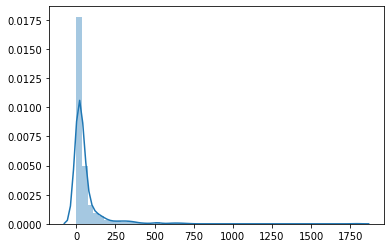

In [30]:
sns.distplot(motion)

In [103]:
m_f = []
mean_intensity =[]
count = 0
i = 0
hof_folder = '..\HOF\\'

for f in lk._motion:
    av = []
    for v in f:
        av.append(math.sqrt(math.pow(v[0][0],2)+math.pow(v[0][1],2)))
    m_f.append(av)
    mean_intensity.append(np.mean(av))




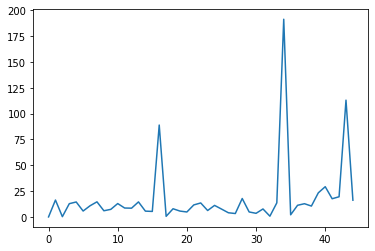

In [104]:
sns.lineplot(range(len(mean_intensity)), mean_intensity)

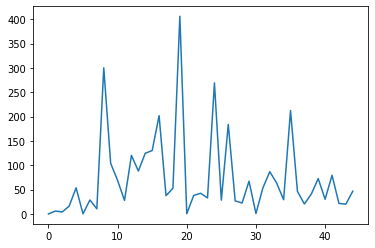

In [101]:
sns.lineplot(range(len(mean_intensity)), mean_intensity)

## Dense Optical Flow

In [ ]:
video_path = "..\\Videos\\026_YOU_FIC_FIS_SEX.mp4"
cap = cv2.VideoCapture(video_path)

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while(1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',rgb)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',rgb)
    prvs = next

cap.release()
cv2.destroyAllWindows()